# New RWZ $Z^{\left(\pm \right)}$ Solver

Aim to solve the RW equation:
\begin{align*}
\left(\frac{d^2}{dr_*^2} + \sigma^2\right) Z^{\left(\pm\right)} - V^{\left(\pm\right)}Z^{\left(\pm\right)} = 0
\end{align*}
using tortoise coordinates only. The axial potential is given by:
\begin{align*}
V^{\left(-\right)} = \left(1 - \frac{2M}{r}\right)\left(\frac{l\left(l+1\right)}{r^2} - \frac{6M}{r^3}\right)
\end{align*}



In [10]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import sparse

def r_to_rstar(r, M):
    r = np.array(r)
    if np.any(r <= 2*M):
        raise ValueError("All r must be > 2M")
    return r + 2*M*np.log(r/(2*M) - 1)

def rstar_to_r(rs, M):
    rs = np.array(rs)
    return (2*M*(1 + lambertw(np.exp(rs/(2*M) - 1)))).real

def Vpm(r, M, l, parity):
    if parity == 'axial':
        V = (1-2*M/r)*(l*(l+1)/r**2 - 6*M/r**3)
    elif parity == 'polar':
        n = 1/2*(l-1)*(l+2)
        num = 2*(1-2*M/r)*(
            9*M**3 +
            9*n*M**2*r + 
            3*n**2*M*r**2 + 
            n**2*(1 + n)*r**3
        )
        den = r**3*(3*M + n*r)**2
        V = num/den
    else:
        raise ValueError("parity needs to be either: axial or polar")
    return V

j = complex(0, 1)

def gaussian_wave(x, t, x0, sigma, omega):
    spatial = np.exp(-(x-x0)**2/(2*sigma**2))
    temporal = np.exp(-j*omega*(x-t))
    y = spatial*temporal
    dydt = j*omega*y
    return y, dydt


In [ ]:
#Time independent
mass = 1
sig = 0.1
mode = 2
eps = 1e-13

r_range = [2*mass + eps, 200*mass]
r_star_range = r_to_rstar(r_range, mass)
r_star_vals = np.linspace(r_star_range[0], r_star_range[-1], 2000)

Z0 = np.exp(-j*sig*r_star_range[0])
dZ0 = -j*sig*Z0
y0 = [Z0, dZ0]

def system(rstar, s, M, sigma, l, parity):
    r = rstar_to_r(rstar, M)
    V = Vpm(r, M, l, parity)
    Z, dZ = s
    return [dZ, (V - sigma**2)*Z]

sol = solve_ivp(system, r_star_range, y0, method = 'RK45', t_eval = r_star_vals, args = (mass, sig, mode, 'axial'))
Z_sol = sol.y[0]

In [ ]:
tsteps = 10
print(np.array(range(tsteps - 1)) + 1)


[1 2 3 4 5 6 7 8 9]
0
1
2
3
4
5
6
7
8
9


Assuming separability of RWZ equation doesn't allow for QNM analysis as in assuming the time dependence form $\sim e^{-\text{i} \sigma t}$ fixes the frequency of the output. Need generalisation in time to perform QNM analysis. The equation thus becomes:
\begin{align*}
\left(\frac{d^2}{dr_*^2} - \frac{d^2}{dt^2}\right) \Psi - V \Psi = 0
\end{align*}

this form makes it apparent how the gaussian initial pulse can be implemented and where ingoing and outgoing boundary conditions come from ($V \rightarrow 0$ as $r_* \rightarrow \pm \infty$ which gives plane wave solutions to the RWZ equation with ingoing and outgoing solutions picked accordingly).

In [ ]:
import numpy as np
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import sparse

def r_to_rstar(r, M):
    r = np.array(r)
    if np.any(r <= 2*M):
        raise ValueError("All r must be > 2M")
    return r + 2*M*np.log(r/(2*M) - 1)

def rstar_to_r(rs, M):
    rs = np.array(rs)
    return (2*M*(1 + lambertw(np.exp(rs/(2*M) - 1)))).real

def Vpm(r, M, l, parity):
    if parity == 'axial':
        V = (1-2*M/r)*(l*(l+1)/r**2 - 6*M/r**3)
    elif parity == 'polar':
        n = 1/2*(l-1)*(l+2)
        num = 2*(1-2*M/r)*(
            9*M**3 +
            9*n*M**2*r + 
            3*n**2*M*r**2 + 
            n**2*(1 + n)*r**3
        )
        den = r**3*(3*M + n*r)**2
        V = num/den
    else:
        raise ValueError("parity needs to be either: axial or polar")
    return V

j = complex(0, 1)

def gaussian_wave(x, t, x0, sigma, omega):
    spatial = np.exp(-(x-x0)**2/(2*sigma**2))
    temporal = np.exp(-j*omega*(x-t))
    y = spatial*temporal
    dydt = j*omega*y
    return y, dydt

#Leapfrog algorithm
M = 1
c = 1
width = 2*M
rstar0 = 0*M
omega = 2
j = complex(0, 1)
ls = [2]

dx = 0.1
dt = 0.5*dx
rstar = np.arange(-5*M, (5+dx)*M, dx)
r = rstar_to_r(rstar, M)
Nr = len(rstar) #spatial points
Nt = 200 #timesteps

# V_all = np.zeros((len(ls), 2, Nr))
# for i, l in enumerate(ls):
#     V_all[i, 0] = Vpm(r, M, l, 'axial')
#     V_all[i, 1] = Vpm(r, M, l, 'polar')

# y = np.zeros((Nr, 3)) #index y as y[xi, tj]
# y[:,0] = (1/(np.sqrt(2*np.pi*width**2)))*np.exp(-(rstar - rstar0)**2/(2*width**2))*np.exp(-j*omega*rstar).real
# y[1:-1, 1] = y[1:-1, 0] + 0.5* c**2*(dt/dx)**2*(y[2:, 0] + y[:-2, 0] - 2*y[1:-1, 0]) # define future step


# for k in range(0, Nt):
#     y[1:-1, 2] = 2*y[1:-1, 1] - y[1:-1, 0] + c**2*(dt/dx)**2*(y[2:,1] + y[:-2, 1] - 2*y[1:-1, 1]) - V_all[0, 0, 1:-1]*y[1:-1, 1]*dt**2
#     y[0, 2] = (1-dt/dx)*y[0, 1] + dt/dx*y[1, 1]
#     y[-1, 2] = (1 - dt/dx)*y[-1, 1] + dt/dx*y[-2, 1]
#     y[:, 0] = y[:, 1]
#     y[:, 1] = y[:, 2]


def leapfrog(rstar: np.ndarray, tsteps: int, mass: float, mode: int, parity: str, 
            y0: np.ndarray, dx: float, dt: float ):
    
    r = rstar_to_r(rstar, mass)
    V = Vpm(r, mass, mode, parity)

    Nr = len(rstar)
    Nt = tsteps

    Psi = np.zeros((Nr, Nt))
    Psi[:, 0] = y0
    Psi[1:-1, 1] = Psi[1:-1, 0] + 0.5*(dt/dx)**2*(Psi[2:, 0] + 
        Psi[:-2, 0] - 2*Psi[1:-1, 0]) - 0.5*V[1:-1]*Psi[1:-1, 0]*dt**2
    
    for q in range(1, Nt - 1):
        Psi[1:-1, q + 1] = ( 2*Psi[1:-1, q] - Psi[1:-1, q - 1]
            + (dt/dx)**2*(Psi[2:, q] + Psi[:-2, q] - 2*Psi[1:-1, q])
            - V[1:-1]*Psi[1:-1, q]*dt**2
        )
        Psi[0, q + 1] = (1-dt/dx)*Psi[0, q] + dt/dx*Psi[1, q]
        Psi[-1, q + 1] = (1 - dt/dx)*Psi[-1, q] + dt/dx*Psi[-2, q]
    
    return Psi


#MAKE INTO A FUNCTION WHICH CAN BE GIVEN AN M, L, OMEGA, WIDTH ETC. AND PRODUCES THE Psi = [Nr, Nt]
#USING LEAPFROG AND SOMMERFELD CONDITIONS THEN EXTRACT DATA AND PLOT IN TIME INTERVALS
#NEED TO CHANGE FOR LOOP SOMEHOW


<class 'numpy.ndarray'>


In [34]:
#Create mesh
M = 1
dx = 0.1
dt = 0.5*dx
ti, tf = 0, 200
rstar_array = np.arange(-200*M, 200*M, dx)
r_array = rstar_to_r(rstar_array, M)
t_array = np.arange(ti, tf, dt)
print(rstar_array.shape, t_array.shape)

D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(rstar_array.size, rstar_array.size)) / dx**2

ls = [2]
Nr = len(rstar_array)

V_all = np.zeros((len(ls), 2, Nr))

for i, l in enumerate(ls):
    V_all[i, 0] = Vpm(r_array, M, l, 'axial')
    V_all[i, 1] = Vpm(r_array, M, l, 'polar')

print(V_all.shape)
def td_system(t, s, mode, parity):
    if parity == 'axial':
        V = V_all[mode - 2, 0]
    elif parity == 'polar':
        V = V_all[mode - 2, 1]
    else:
        raise ValueError("parity needs to be either: axial or polar")

    Psi = s[:len(rstar_array)]
    dPsi = s[len(rstar_array):]
    d2Psi = D2.dot(Psi) - V*Psi

    return np.concatenate([dPsi, d2Psi])

# #Initial conditions
rstar0 = 30*M
omega = 2
gaussian_width = 3*M
Psi0 = (1/np.sqrt(2*np.pi*gaussian_width**2))*np.exp(-(rstar_array-rstar0)**2/(2*(gaussian_width)**2))*np.exp(j*omega*(- rstar_array))
dPsi0 = j*omega*Psi0
s0 = np.concatenate([Psi0, dPsi0])

# #Try without boundary conditions
# sol = solve_ivp(fun = td_system, t_span = [ti, tf], y0 = s0, method='RK45', t_eval = t_array, args = [2, 'axial'], rtol = 1e-12, atol = 1e-15)
# print(sol.y.shape)
# Psi_sol = sol.y[:len(rstar_array)]
# dPsi_sol = sol.y[len(rstar_array):]
# Psi_sol = Psi_sol.transpose()
# dPsi_sol = dPsi_sol.transpose()
# print(Psi_sol.shape)

(4000,) (4000,)
(1, 2, 4000)


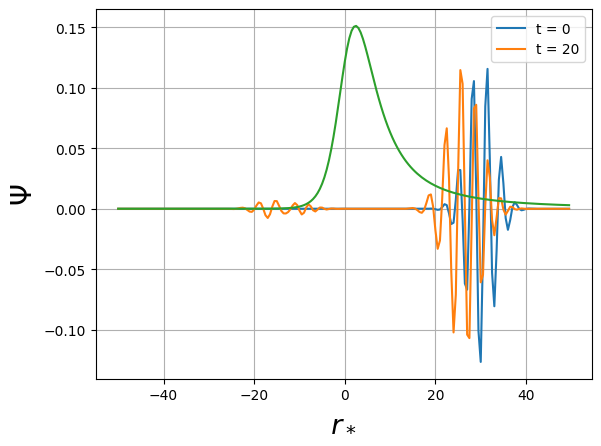

In [33]:
plt.figure()
plt.plot(rstar_array, Psi_sol[0], label = 't = 0')
plt.plot(rstar_array, Psi_sol[-1], label = 't = 20')
plt.plot(rstar_array, V_all[0, 0])
plt.xlabel(r'$r_*$', fontsize = 20)
plt.ylabel(r'$\Psi$', fontsize = 20)
plt.legend()
plt.grid()
plt.show()
